In [1]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate
from scipy.stats import norm

from tropical_cyclone_dm import TropicalCycloneSequenceDataModule

plt.rcParams["figure.figsize"] = [14, 5]

color_palette = {
    # Classification
    "DKLClassification": "#2ca02c",  # Green
    "LaplaceClassification": "#d62728",  # Red
    "DeepEnsembleClassification": "#9467bd",  # Purple
    "MCDropoutClassification": "#8c564b",  # Brown
    "SWAGClassification": "#e377c2",  # Pink
    "BNN_VI_ELBO_Classification": "#7f7f7f",  # Gray
    "DER": "#bcbd22",  # Lime
    "DUEClassification": "#17becf",  # Teal
    "DeterministicClassification": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARDClassification": "#98df8a",
    "TempScaling": "#ff9896",  # Light Red

    # regression
    "MVERegression": "#1f77b4",  # Blue
    "QuantileRegression": "#ff7f0e",  # Orange
    "DKLRegression": "#2ca02c",  # Green
    "LaplaceRegression": "#d62728",  # Red
    "DeepEnsembleRegression": "#9467bd",  # Purple
    "MCDropoutRegression": "#8c564b",  # Brown
    "SWAGRegression": "#e377c2",  # Pink
    "BNN_VI_ELBO_Regression": "#7f7f7f",  # Gray
    "BNN_VI_Regression": "#bcbd25",  # Lime
    "DER": "#bcbd22",  # Lime
    "DUERegression": "#17becf",  # Teal
    "DeterministicRegression": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARDRegression": "#98df8a",
}

VAR_TO_PLOT_LABEL = {
    "mae": "MAE",
    "rmse": "RMSE",
    "pred_uct": "Pred. Uncertainty",
    "coverage": "Coverage",
    "sharpness": "Sharpness",
    "calibration": "Calibration",
    "correlation": "Correlation",
    "nll": "NLL",
    "mace": "MACE",
    "crps": "CRPS",
    "proportion_in_0.9_interval": "Proportion in 0.9 Interval",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "H1": "Cat 1 Hurricane",
    "H2": "Cat 2 Hurricane",
    "H3": "Cat 3 Hurricane",
    "H4": "Cat 4 Hurricane",
    "H5": "Cat 5 Hurricane",
    "DKLClassification": "DKL",
    "LaplaceClassification": "Laplace",
    "DeepEnsembleClassification": "Deep Ensemble",
    "MCDropoutClassification": "MC Dropout",
    "SWAGClassification": "SWAG",
    "BNN_VI_ELBO_Classification": "BNN VI ELBO",
    "DUEClassification": "DUE",
    "DeterministicClassification": "Deterministic",
    "CARDClassification": "CARD",
    "MVERegression": "MVE",
    "QuantileRegression": "Quantile",
    "DKLRegression": "DKL",
    "LaplaceRegression": "Laplace",
    "DeepEnsembleRegression": "Deep Ensemble",
    "MCDropoutRegression": "MC Dropout",
    "SWAGRegression": "SWAG",
    "BNN_VI_ELBO_Regression": "BNN VI ELBO",
    "BNN_VI_Regression": "BNN VI",
    "DER": "DER",
    "DUERegression": "DUE",
    "DeterministicRegression": "Deterministic",
    "ConformalQR": "Conformal QR",
    "CARDRegression": "CARD",
}

%load_ext autoreload
%autoreload 2

In [2]:
# specify directories to include in analysis
directories = [
    "/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0",
    # "/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34",
    # "/p/project/hai_uqmethodbox/experiment_output/test_class_kl_div",
    # "/p/project/hai_uqmethodbox/experiment_output/test_class",
    "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new",
]
paths = [
    file
    for directory in directories
    for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))
    if os.path.exists(os.path.join(os.path.dirname(file), "config.yaml"))
]


# selective prediction threshold
SELECTIVE_THRESH = 12

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())


# choosee one type of selective prediction procedure from ["absolute", "method", "category_conditional"]
SELECTIVE_PROCEDURE = "absolute"

# TODO map them to readable names
STORM_DISPLAY_ORDER = ["all", "TD", "TS", "H1", "H2", "H3", "H4", "H5"]

DS_SPLIT = "test"


# Define your lists of methods
CLASSIFICATION_METHODS = [
    "DeterministicClassification",
    "DeepEnsembleClassification",
    "MCDropoutClassification",
    "SWAGClassification",
    "LaplaceClassification",
    "BNN_VI_ELBO_Classification",
    "DKLClassification",
    "DUEClassification",
    "CARDClassification",
]

REGRESSION_METHODS = [
    'DeterministicRegression',
    "MVERegression",
    "DeepEnsembleRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "LaplaceRegression",
    "BNN_VI_Regression",
    "DER",
    "BNN_VI_ELBO_Regression",
    "DKLRegression",
    "DUERegression",
    "QuantileRegression",
    'ConformalQR',
    "CARDRegression"
]


UQ_METHOD_DISPLAY_ORDER = [
    "DeterministicClassification",
    "DeepEnsembleClassification",
    "MCDropoutClassification",
    "SWAGClassification",
    "LaplaceClassification",
    "BNN_VI_ELBO_Classification",
    "DKLClassification",
    "DUEClassification",
    "CARDClassification",
]

# Define the groups
UQ_METHOD_GROUPS = {
    "Bayesian": [
        "MCDropoutClassification",
        "SWAGClassification",
        "LaplaceClassification",
        "BNN_VI_ELBO_Classification",
        "DKLClassification",
        "DUEClassification",
    ],
    "Ensemble": ["DeepEnsembleClassification"],
    "Diffusion": ["CARDClassification"],
}

In [3]:
paths

['/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DUEClassification_02-26-2024_21-08-45-497203/preds_val.csv',
 '/p/project/hai_uqmethodb

In [4]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        try:
            conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        except FileNotFoundError:
            print(f"Config not found for {path}")
            continue
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]

        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, "%m-%d-%Y")
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = re.sub(r"preds_.*\.csv", "config.yaml", path)
        exp_dict["metric_path"] = os.path.join(
            os.path.dirname(path), "csv_logs", "version_0", "metrics.csv"
        )
        conf = OmegaConf.load(exp_dict["conf_path"])
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df


overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,SWAGClassification,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...
1,SWAGClassification,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...
2,SWAGClassification,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...
3,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...
4,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...,/p/project/hai_uqmethodbox/experiment_output/c...
...,...,...,...,...
58,DER,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
59,DER,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
60,MVERegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
61,MVERegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...


In [5]:
with pd.option_context("display.max_colwidth", None):
    display(overview_df.conf_path)

0             /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/config.yaml
1             /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/config.yaml
2             /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/config.yaml
3     /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/config.yaml
4     /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/config.yaml
                                                                        ...                                                                   
58                        /p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DER_02-01-2024_08-40-15-469560/config.yaml

In [6]:
datamodule = instantiate(OmegaConf.load(overview_df.conf_path.iloc[0]).datamodule)
datamodule.setup("fit")
datamodule.setup(stage="test")

In [7]:
dataset = datamodule.dataset
train_ds = datamodule.train_dataset
val_ds = datamodule.val_dataset
test_ds = datamodule.test_dataset
calib_ds = datamodule.calibration_dataset

print(len(dataset)), print(len(train_ds)), print(len(val_ds)), print(
    len(calib_ds)
), print(len(test_ds))
# ds = datamodule.test_dataset.dataset
bin_size = 5
WIND_SPEED_BINS = list(
            range(
                0,
                180+ 2*bin_size,
                bin_size,
            )
        )


DS_DICT = {"train": dataset, "val": dataset, "test": test_ds}
print(WIND_SPEED_BINS), print(len(WIND_SPEED_BINS))

69267
56348
10335
2584
43635
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185]
38


(None, None)

In [8]:
bin_intervals = np.diff(WIND_SPEED_BINS)
bin_intervals = (np.append(bin_intervals, bin_intervals[-1]) / 2) + WIND_SPEED_BINS
bin_intervals, len(bin_intervals)

(array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
         47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
         92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
        137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
        182.5, 187.5]),
 38)

In [9]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule

    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()


def get_normalization_params_from_df(pred_path):
    config = OmegaConf.load(os.path.join(pred_path, "config.yaml"))
    target_mean, target_std = get_target_normalization_params(config)
    return {pred_path: {"target_mean": target_mean, "target_std": target_std}}


def get_normalization_params_from_df_wrapper(path):
    try:
        return get_normalization_params_from_df(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_normalization_params_in_parallel(paths, num_processes):
    with Pool(processes=num_processes) as pool:
        results = list(
            tqdm(
                pool.imap(get_normalization_params_from_df_wrapper, paths),
                total=len(paths),
            )
        )
    results = {
        k: v for result in results if result is not None for k, v in result.items()
    }
    return results


num_processes = 8
os.environ["HYDRA_FULL_ERROR"] = "1"
dir_paths = list(
    set(
        [
            os.path.dirname(path)
            for path in paths
            if any(
                condition in path for condition in ["Regression", "ConformalQR", "DER"]
            )
        ]
    )
)
NORMALIZATION_PARAMS = compute_normalization_params_in_parallel(
    dir_paths, num_processes
)
NORMALIZATION_PARAMS

100%|██████████| 14/14 [01:01<00:00,  4.40s/it]


{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_ConformalQR_02-01-2024_16-18-46-884229': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_LaplaceRegression_02-01-2024_08-41-50-208354': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_CARDRegression_02-02-2024_10-26-30-553099': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experimen

# Compute all predictions full df

In [10]:
import pandas as pd

from scipy.stats import norm
from scipy.optimize import curve_fit
from tqdm import trange, tqdm
from joblib import Parallel, delayed


# Define a function to fit a Gaussian
def fit_gaussian(x, mean, std_dev):
    return norm.pdf(x, mean, std_dev)


def fit_gaussian_to_row(row, bin_midpoints):
    p0 = [np.mean(row), np.std(row) + 1e-5]
    try:
        popt, _ = curve_fit(fit_gaussian, bin_midpoints, row, p0=p0, maxfev=2000)
    except RuntimeError:
        print(row)
        print(bin_midpoints)
    return popt


def process_overview_df(overview_df):
    overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]

    all_test_pred_df = []
    for idx, row in overview_df.iterrows():
        pred_df = pd.read_csv(row["pred_path"])
        pred_df["uqmethod"] = row["uqmethod"]
        if row["split"] == "preds.csv":
            pred_df["split"] = "preds_test"
        else:
            pred_df["split"] = row["split"].split(".")[0]

        pred_df["pred_path"] = row["pred_path"]
        all_test_pred_df.append(pred_df)

    all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)

    # all_test_pred_df = all_test_pred_df[(all_test_pred_df["uqmethod"] == "DKLClassification") & (all_test_pred_df["split"] == "preds_test")]

    # date
    pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

    # Extract dates and create a new column
    all_test_pred_df["date"] = all_test_pred_df["pred_path"].str.extract(pattern)

    # Convert the new_date_column to datetime format
    all_test_pred_df["date"] = pd.to_datetime(
        all_test_pred_df["date"], format="%m-%d-%Y_%H-%M"
    )

    def compute_bin_mean_prediction(x, bin_edges):
        # x = row["pred"]
        if x < len(bin_edges) - 1:
            return (bin_edges[x] + bin_edges[x + 1]) / 2
        else:
            # extend the last category bin
            return (bin_edges[x] + dataset.class_bin_size) / 2

    # argmax Classification prediction
    conditions = ["Classification", "TempScaling"]
    pattern = "|".join(conditions)
    if any(all_test_pred_df["pred_path"].str.contains(pattern)):
        # argmax Classification prediction
        all_test_pred_df["argmax_reg"] = all_test_pred_df.apply(
            lambda row: (
                compute_bin_mean_prediction(int(row["pred"]), WIND_SPEED_BINS)
                if any(condition in row["uqmethod"] for condition in conditions)
                else np.nan
            ),
            axis=1,
        )

        # weighted softmax Classification prediction
        logit_cols = [
            col for col in all_test_pred_df.columns if col.startswith("logit_")
        ]

        # Compute softmax values for each logit
        exp_logits = all_test_pred_df.loc[
            all_test_pred_df["uqmethod"].str.contains(pattern), logit_cols
        ].values.copy()
        softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

        # Compute bin intervals
        bin_intervals = np.diff(WIND_SPEED_BINS) / 2
        bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

        # Compute weighted average of the softmax over the logits
        all_test_pred_df.loc[
            all_test_pred_df["uqmethod"].str.contains(pattern), "softmax_weighted_reg"
        ] = np.sum(softmax_values * bin_midpoints, axis=1)

    # all_test_pred_df['argmax_reg'] = all_test_pred_df.apply(lambda row: compute_bin_mean_prediction(row, WIND_SPEED_BINS), axis=1)

    # # weighted softamx Classification prediction
    # logit_cols = [col for col in all_test_pred_df.columns if col.startswith('logit_')]

    # # Compute softmax values for each logit
    # exp_logits = np.exp(all_test_pred_df[logit_cols].values.copy())
    # softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # # Compute bin intervals
    # bin_intervals = np.diff(WIND_SPEED_BINS) / 2
    # bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

    # # Compute weighted average of the softmax over the logits
    # all_test_pred_df['softmax_weighted_reg'] = np.sum(softmax_values * bin_midpoints, axis=1)

    # logits = all_test_pred_df[logit_cols].values

    # logits_softplus = np.log1p(np.exp(logits))
    # logits_softplus_sum = np.sum(logits_softplus, axis=1, keepdims=True)
    # # logits_softplus_normalized = logits_softplus / logits_softplus_sum
    # logits_softplus_sum += 1e-3

    # # Fit a Gaussian to the softmax logits
    # gaussian_params = Parallel(n_jobs=12)(delayed(fit_gaussian_to_row)(row, np.arange(len(logit_cols))) for row in tqdm(logits_softplus_sum, desc="Fitting Gaussians"))
    # # Convert the list of tuples into a DataFrame
    # gaussian_params_df = pd.DataFrame(gaussian_params, columns=['gaussian_mean', 'gaussian_std'])

    # # # Assign the columns of the DataFrame to new columns in all_test_pred_df
    # all_test_pred_df[['gaussian_mean', 'gaussian_std']] = gaussian_params_df

    all_test_pred_df = all_test_pred_df.reset_index(drop=True)

    # Create a new column 'method_type' in the DataFrame
    all_test_pred_df['method_type'] = all_test_pred_df['uqmethod'].apply(lambda x: 'Classification' if x in CLASSIFICATION_METHODS else ('Regression' if x in REGRESSION_METHODS else 'Unknown'))

    
    mask = all_test_pred_df['method_type'] == 'Regression'
    all_test_pred_df.loc[mask, 'TARGET_MEAN'] = all_test_pred_df.loc[mask, 'pred_path'].map(lambda x: NORMALIZATION_PARAMS[os.path.dirname(x)]['target_mean'])
    all_test_pred_df.loc[mask, 'TARGET_STD'] = all_test_pred_df.loc[mask, 'pred_path'].map(lambda x: NORMALIZATION_PARAMS[os.path.dirname(x)]['target_std'])

    # Apply normalization only to those rows
    all_test_pred_df.loc[mask, "pred"] = all_test_pred_df.loc[mask, "pred"] * all_test_pred_df.loc[mask, 'TARGET_STD'] + all_test_pred_df.loc[mask, 'TARGET_MEAN']
    all_test_pred_df.loc[mask, "target"] = all_test_pred_df.loc[mask, "target"] * all_test_pred_df.loc[mask, 'TARGET_STD'] + all_test_pred_df.loc[mask, 'TARGET_MEAN']
    all_test_pred_df.loc[mask, "pred_uct"] = all_test_pred_df.loc[mask, "pred_uct"] * all_test_pred_df.loc[mask, 'TARGET_STD']

    # if "wind_speed" column has nans, copy the "target" column to "wind_speed"
    all_test_pred_df["wind_speed"] = all_test_pred_df["wind_speed"].fillna(all_test_pred_df["target"])

    # if argmax_reg column has nans, copy the pred column to a new column called point_pred
    all_test_pred_df["point_pred"] = all_test_pred_df["argmax_reg"].fillna(all_test_pred_df["pred"])

    # compute squared error
    all_test_pred_df["mse"] = (all_test_pred_df["point_pred"] - all_test_pred_df["wind_speed"]) ** 2
    # compute mean absolute error
    all_test_pred_df["mae"] = np.abs(all_test_pred_df["point_pred"] - all_test_pred_df["wind_speed"])

    all_test_pred_df["storm_category"] = pd.cut(
        all_test_pred_df["wind_speed"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
    )

    return all_test_pred_df


all_test_pred_df = process_overview_df(overview_df)
all_test_pred_df

,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,date,argmax_reg,softmax_weighted_reg,method_type,TARGET_MEAN,TARGET_STD,point_pred,mse,mae,storm_category
0,5.000000,1.190447,5.000000,nkd,34356.0,25.000000,-7.853996,-7.498690,-7.753402,1.351465,...,NaT,27.5,129.237349,Classification,NaN,NaN,27.500000,6.250000,2.500000,TD
1,7.000000,1.534693,7.000000,aya,2398.0,35.000000,-8.909798,-8.659307,-8.899755,-0.869892,...,NaT,37.5,130.152778,Classification,NaN,NaN,37.500000,6.250000,2.500000,TS
2,5.000000,0.865020,5.000000,cjx,5222.0,25.000000,-6.600438,-6.494703,-6.887533,1.492285,...,NaT,27.5,124.909722,Classification,NaN,NaN,27.500000,6.250000,2.500000,TD
3,10.000000,1.949137,7.000000,ohj,35834.0,35.000000,-6.481304,-6.200682,-6.615491,-4.231768,...,NaT,52.5,131.657373,Classification,NaN,NaN,52.500000,306.250000,17.500000,TS
4,6.000000,1.697599,6.000000,kyq,30675.0,31.000000,-6.541611,-6.873618,-6.895798,-2.910524,...,NaT,32.5,127.460083,Classification,NaN,NaN,32.500000,2.250000,1.500000,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316686,80.221814,7.798797,92.000000,NaN,NaN,92.000000,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,80.221814,138.725658,11.778186,H2
2316687,106.431883,9.872610,95.000002,NaN,NaN,95.000002,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,106.431883,130.687900,11.431881,H3
2316688,39.071689,6.626147,33.999999,NaN,NaN,33.999999,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,39.071689,25.722045,5.071691,TS
2316689,74.180720,8.883380,73.999999,NaN,NaN,73.999999,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,74.180720,0.032660,0.180721,H1


In [11]:
all_test_pred_df[all_test_pred_df["uqmethod"] == "SWAGRegression"]

,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,date,argmax_reg,softmax_weighted_reg,method_type,TARGET_MEAN,TARGET_STD,point_pred,mse,mae,storm_category
1654777,30.866813,13.181137,34.999998,NaN,NaN,34.999998,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,30.866813,17.083224,4.133186,TS
1654778,34.796144,11.206396,24.999998,NaN,NaN,24.999998,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,34.796144,95.964471,9.796146,TD
1654779,38.379808,10.898664,33.999999,NaN,NaN,33.999999,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,38.379808,19.182733,4.379810,TS
1654780,39.058749,14.734259,31.999999,NaN,NaN,31.999999,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,39.058749,49.825945,7.058750,TD
1654781,20.249999,8.592734,19.999997,NaN,NaN,19.999997,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,20.249999,0.062501,0.250003,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765091,33.220044,12.560833,38.999998,NaN,NaN,38.999998,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,33.220044,33.407869,5.779954,TS
1765092,16.589952,9.650902,15.000001,NaN,NaN,15.000001,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,16.589952,2.527945,1.589951,TD
1765093,31.217856,12.521849,29.999998,NaN,NaN,29.999998,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,31.217856,1.483177,1.217858,TD
1765094,27.793493,10.627805,22.999999,NaN,NaN,22.999999,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,27.793493,22.977584,4.793494,TD


# Selective Prediction

In [12]:
SELECTIVE_PROCEDURE = "method"


def compute_quantile_and_save(
    paths: list[str],
    quantiles: list[float] = [
        0.95,
        0.9,
        0.85,
        0.8,
        0.75,
        0.7,
        0.65,
        0.6,
        0.55,
        0.5,
        0.45,
        0.4,
        0.35,
        0.3,
        0.25,
        0.2,
        0.15,
        0.1,
        0.05,
    ],
):
    selective_pred_dict = {}
    for path in paths:
        # assert "val" in path
        df = pd.read_csv(path)
        # Compute 0.9 quantile
        if "pred_uct" in df.columns:
            if SELECTIVE_PROCEDURE == "method":
                if "Regression" in path:
                    TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(path)][
                        "target_std"
                    ]
                    df["pred_uct"] = df["pred_uct"] * TARGET_STD
                # create a dict over all storm categories and fill values with method threshold, independent of category
                quant_dict = {
                    quantile: df["pred_uct"].quantile(quantile)
                    for quantile in quantiles
                }
        selective_pred_dict[os.path.dirname(path)] = quant_dict
    return selective_pred_dict


dir_paths = [path for path in paths if "val" in path]
SELECTIVE_PRED_DICT = compute_quantile_and_save(dir_paths)
SELECTIVE_PRED_DICT

{'/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712': {0.95: 2.4487851999999997,
  0.9: 2.3477568000000004,
  0.85: 2.28372749,
  0.8: 2.23354292,
  0.75: 2.1849679,
  0.7: 2.1370324399999996,
  0.65: 2.08479698,
  0.6: 2.01943006,
  0.55: 1.9511031500000002,
  0.5: 1.8899411,
  0.45: 1.8286739200000002,
  0.4: 1.76339716,
  0.35: 1.70741473,
  0.3: 1.6529201999999998,
  0.25: 1.580089,
  0.2: 1.48233558,
  0.15: 1.33496712,
  0.1: 1.17328664,
  0.05: 1.0650525100000001},
 '/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274': {0.95: 2.54122186,
  0.9: 2.40514122,
  0.85: 2.31793843,
  0.8: 2.23804344,
  0.75: 2.17438885,
  0.7: 2.1100540999999997,
  0.65: 2.0543278099999998,
  0.6: 1.99789534,
  0.55: 1.93967402,
  0.5: 1.8776782,
  0.45: 1.81880369,
  0.4: 1.75235632,
  0.35: 1.6786069399999999,
  0.3: 1.58874602,
  0.25: 1.4633192,
  0.2: 1.3034

In [13]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Initialize an empty DataFrame to store the RMSE
rmse_df = pd.DataFrame(columns=["pred_path", "threshold", "RMSE"])

# Iterate over each unique "pred_path" in all_test_pred_df
for pred_path in tqdm(all_test_pred_df["pred_path"].unique()):
    exp_path = os.path.dirname(pred_path)
    # split = all_test_pred_df.loc[all_test_pred_df['pred_path'] == pred_path, 'split'].iloc[0]
    # uq_method = all_test_pred_df.loc[all_test_pred_df['pred_path'] == pred_path, 'uqmethod'].iloc[0]
    # Check if the current "pred_path" is in SELECTIVE_PRED_DICT
    if exp_path in SELECTIVE_PRED_DICT:
        path_df = all_test_pred_df[(all_test_pred_df["pred_path"] == pred_path)]

        full_rmse = mean_squared_error(
            path_df["point_pred"], path_df["wind_speed"], squared=False
        )
        row_df = pd.DataFrame(
            {"pred_path": [pred_path], "threshold": [1.0], "RMSE": [full_rmse]}
        )
        rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)
        # Iterate over each threshold
        for threshold, value in SELECTIVE_PRED_DICT[exp_path].items():

            filtered_df = path_df[(path_df["pred_uct"] <= value)]
            if len(filtered_df) != 0:
                # Compute the RMSE for the filtered DataFrame
                rmse = mean_squared_error(
                    filtered_df["point_pred"], filtered_df["wind_speed"], squared=False
                )

                # Create a new DataFrame for the current row
                row_df = pd.DataFrame(
                    {"pred_path": [pred_path], "threshold": [threshold], "RMSE": [rmse]}
                )
            else:
                row_df = pd.DataFrame(
                    {
                        "pred_path": [pred_path],
                        "threshold": [threshold],
                        "RMSE": [np.nan],
                    }
                )

            # Concatenate the new row with rmse_df
            rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)

# add meta data
meta_df = all_test_pred_df.drop_duplicates(subset=["pred_path"])
rmse_df = rmse_df.merge(
    meta_df[["pred_path", "split", "uqmethod"]], on="pred_path", how="left", suffixes=('', '_meta')
)

# Display the RMSE DataFrame
print(rmse_df)

  0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_22299/659055923.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)
100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                                              pred_path  threshold       RMSE  \
0     /p/project/hai_uqmethodbox/experiment_output/c...       1.00  11.126696   
1     /p/project/hai_uqmethodbox/experiment_output/c...       0.95  10.566104   
2     /p/project/hai_uqmethodbox/experiment_output/c...       0.90  10.242502   
3     /p/project/hai_uqmethodbox/experiment_output/c...       0.85   9.852209   
4     /p/project/hai_uqmethodbox/experiment_output/c...       0.80   9.517566   
...                                                 ...        ...        ...   
1255  /p/project/hai_uqmethodbox/experiment_output/m...       0.25   4.177798   
1256  /p/project/hai_uqmethodbox/experiment_output/m...       0.20   3.806683   
1257  /p/project/hai_uqmethodbox/experiment_output/m...       0.15   3.430623   
1258  /p/project/hai_uqmethodbox/experiment_output/m...       0.10   3.149043   
1259  /p/project/hai_uqmethodbox/experiment_output/m...       0.05   2.895120   

            split          

In [14]:
with pd.option_context("display.max_colwidth", None):
    display(rmse_df)

,pred_path,threshold,RMSE,split,uqmethod
0,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,1.00,11.126696,preds_val,SWAGClassification
1,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.95,10.566104,preds_val,SWAGClassification
2,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.90,10.242502,preds_val,SWAGClassification
3,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.85,9.852209,preds_val,SWAGClassification
4,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.80,9.517566,preds_val,SWAGClassification
...,...,...,...,...,...
1255,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_02-01-2024_09-53-51-751149/preds_train.csv,0.25,4.177798,preds_train,MVERegression
1256,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_02-01-2024_09-53-51-751149/preds_train.csv,0.20,3.806683,preds_train,MVERegression
1257,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_02-01-2024_09-53-51-751149/preds_train.csv,0.15,3.430623,preds_train,MVERegression
1258,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_02-01-2024_09-53-51-751149/preds_train.csv,0.10,3.149043,preds_train,MVERegression


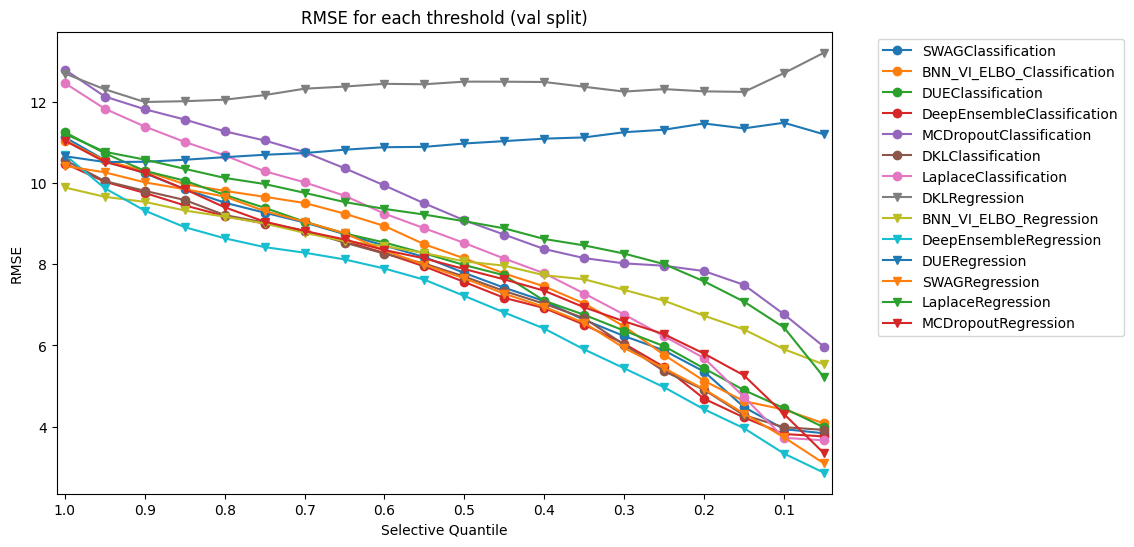

In [15]:
import matplotlib.pyplot as plt


def plot_rmse(rmse_df, DS_SPLIT):
    # Filter the DataFrame for the given DS_SPLIT
    split_df = rmse_df[rmse_df["split"] == f"preds_{DS_SPLIT}"]

    # Get the unique pred_paths
    pred_paths = split_df["pred_path"].unique()

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot a line for each pred_path
    for pred_path in pred_paths:
        path_df = split_df[split_df["pred_path"] == pred_path]
        method = path_df["uqmethod"].iloc[0]
        path_df = path_df.sort_values("threshold", ascending=False)
        if any(
            condition in pred_path for condition in ["Regression", "ConformalQR", "DER"]
        ):
            marker = "v-"
        else:
            marker = "o-"
        plt.plot(path_df["threshold"], path_df["RMSE"], marker, label=method)

    # Add labels and title
    plt.xlim(max(path_df["threshold"]) + 0.01, min(path_df["threshold"]) - 0.01)
    start, end = plt.xlim()
    plt.xticks(
        np.arange(max(path_df["threshold"]), min(path_df["threshold"]), step=-0.1)
    )  # adjust the step size as needed
    plt.xlabel("Selective Quantile")
    plt.ylabel("RMSE")
    plt.title(f"RMSE for each threshold ({DS_SPLIT} split)")

    # Add a legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Show the plot
    plt.show()


# Call the function
to_plot_df = rmse_df[
    rmse_df["uqmethod"].isin(
        [
            "BNN_VI_ELBO_Classification",
            "BNN_VI_ELBO_Regression",
            "MCDropoutClassification",
            "MCDropoutRegression",
            "DKLClassification",
            "DKLRegression",
            "DUEClassification",
            "DUERegression",
            "DeepEnsembleClassification",
            "DeepEnsembleRegression",
            "SWAGClassification",
            "SWAGRegression",
            "LaplaceClassification",
            "LaplaceRegression",
        ]
    )
]
plot_rmse(to_plot_df, "val")

In [31]:
group_cols = ["uqmethod", "pred_path", "storm_category"]
category_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"].groupby(group_cols, observed=False)[['mse', "mae"]].mean().apply(np.sqrt)
# drop nan values
category_df = category_df.dropna()

with pd.option_context("display.max_colwidth", None):
    display(category_df.head(50))

mse  \
uqmethod                   pred_path                                                                                                                                   storm_category              
BNN_VI_ELBO_Classification /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_test.csv TD               7.701276   
                                                                                                                                                                       TS              10.298043   
                                                                                                                                                                       H1              14.139668   
                                                                                                                                                                       H2              16.845264   
                                                                                                                                                                       H3              19.481192   
                                                                                                                                                                       H4              13.612574   
                                                                                                                                                                       H5              18.881072   
BNN_VI_ELBO_Regression     /p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445/preds_test.csv  TD               6.478536   
                                                                                                                                                                       TS               8.360837   
                                                                                                                                                                       H1              13.405060   
                                                                                                                                                                       H2              13.377337   
                                                                                                                                                                       H3              17.175112   
                                                                                                                                                                       H4              15.703085   
                                                                                                                                                                       H5              16.580927   
BNN_VI_Regression          /p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_Regression_02-26-2024_10-40-18-557918/preds_test.csv       TD               8.151825   
                                                                                                                                                                       TS               8.918031   
                                                                                                                                                                       H1              14.409426   
                                                                                                                                                                       H2              17.683122   
                                                                                                                                                                       H3              22.456768   
                                                                         

# Compute metrics across categories

In [39]:
def compute_metrics(all_test_pred_df, quantile=0.95):
    group_cols = ["uqmethod", "pred_path", "storm_category"]

    # Compute rmse per category
    category_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"].groupby(group_cols, observed=False)[['mse', "mae"]].mean().apply(np.sqrt)

    category_df = category_df.dropna()
    category_df = category_df.reset_index()

    # rename mse to rmse column
    category_df = category_df.rename(columns={"mse": "rmse"})

    category_df["split"] = (
        category_df["pred_path"].str.rsplit("/", n=1).str[-1].str.rsplit(".").str[0]
    )

    corr_one = "mae"
    corr_two = "pred_uct"
    filtered_df = all_test_pred_df[
        (all_test_pred_df["split"] == f"preds_{DS_SPLIT}")
        & (all_test_pred_df["uqmethod"] != "DeterministicRegression")
    ]


    # Compute the correlation matrix
    corr_df = (
        filtered_df.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    # Compute the aggregate correlation
    aggregate_corr_df = (
        filtered_df.groupby("uqmethod", observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    # Add a 'storm_category' column to the aggregate correlation DataFrame
    aggregate_corr_df["storm_category"] = "all"

    # Append the aggregate correlation to the correlation DataFrame
    corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

    # Create a pivot table with 'uqmethod' and 'storm_category' as the index and columns, and the correlation between 'pred_uct' and 'mae' as the values
    pivot_table = corr_df.pivot_table(
        index="uqmethod", columns="storm_category", values="mae"
    )

    # Reset the index of the pivot table
    pivot_table_reset = pivot_table.reset_index()

    # Melt the pivot table
    final = pivot_table_reset.melt(id_vars='uqmethod')

    # final["uqmethod"] = corr_df["uqmethod"].unique().tolist() * 8
    final.columns = ["uqmethod", "storm_category", "correlation"]

    # Convert 'uqmethod' column to string in both DataFrames
    category_df['uqmethod'] = category_df['uqmethod'].astype(str)
    final['uqmethod'] = final['uqmethod'].astype(str)


    # Now perform the merge operation
    category_df = category_df.merge(
        final, on=["uqmethod", "storm_category"], how="left"
    )
    # columns_to_check = ["mse", "mae", "nll", "sharpness", "rmse"]
    # category_df = category_df.dropna(subset=columns_to_check)

    category_df["storm_category"] = category_df["storm_category"].astype("category")

    meta_df = all_test_pred_df.drop_duplicates(subset=["pred_path"])

    category_df = category_df.merge(
        meta_df[["pred_path", "method_type"]], on="pred_path", how="left"
    )
    # 
        

    return category_df


category_df = compute_metrics(all_test_pred_df)
category_df

/tmp/ipykernel_22299/1281134056.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())
/tmp/ipykernel_22299/1281134056.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())


,uqmethod,pred_path,storm_category,rmse,mae,split,correlation,method_type
0,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/c...,TD,7.701276,2.353458,preds_test,0.725364,Classification
1,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/c...,TS,10.298043,2.871476,preds_test,0.552462,Classification
2,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/c...,H1,14.139668,3.327776,preds_test,0.563991,Classification
3,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/c...,H2,16.845264,3.674480,preds_test,0.565939,Classification
4,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/c...,H3,19.481192,3.884613,preds_test,0.548324,Classification
...,...,...,...,...,...,...,...,...
142,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,13.804647,3.319912,preds_test,0.375174,Regression
143,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,14.761012,3.391606,preds_test,0.564114,Regression
144,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,16.306905,3.526461,preds_test,0.649080,Regression
145,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H4,16.083288,3.359801,preds_test,0.660919,Regression


In [17]:
all_test_pred_df[all_test_pred_df["uqmethod"]=="SWAGRegression"]

,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,date,argmax_reg,softmax_weighted_reg,method_type,TARGET_MEAN,TARGET_STD,point_pred,mse,mae,storm_category
1654777,30.866813,13.181137,34.999998,NaN,NaN,34.999998,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,30.866813,17.083224,4.133186,TS
1654778,34.796144,11.206396,24.999998,NaN,NaN,24.999998,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,34.796144,95.964471,9.796146,TD
1654779,38.379808,10.898664,33.999999,NaN,NaN,33.999999,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,38.379808,19.182733,4.379810,TS
1654780,39.058749,14.734259,31.999999,NaN,NaN,31.999999,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,39.058749,49.825945,7.058750,TD
1654781,20.249999,8.592734,19.999997,NaN,NaN,19.999997,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,20.249999,0.062501,0.250003,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765091,33.220044,12.560833,38.999998,NaN,NaN,38.999998,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,33.220044,33.407869,5.779954,TS
1765092,16.589952,9.650902,15.000001,NaN,NaN,15.000001,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,16.589952,2.527945,1.589951,TD
1765093,31.217856,12.521849,29.999998,NaN,NaN,29.999998,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,31.217856,1.483177,1.217858,TD
1765094,27.793493,10.627805,22.999999,NaN,NaN,22.999999,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,Regression,50.344008,26.795277,27.793493,22.977584,4.793494,TD


/tmp/ipykernel_22299/2051353244.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['TD', 'TS', 'H1', 'H2', 'H3', ..., 'H1', 'H2', 'H3', 'H4', 'H5']
Length: 147
Categories (8, object): ['all' < 'TD' < 'TS' < 'H1' < 'H2' < 'H3' < 'H4' < 'H5']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  plot_cat_df.loc[:, "storm_category"] = pd.Categorical(
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

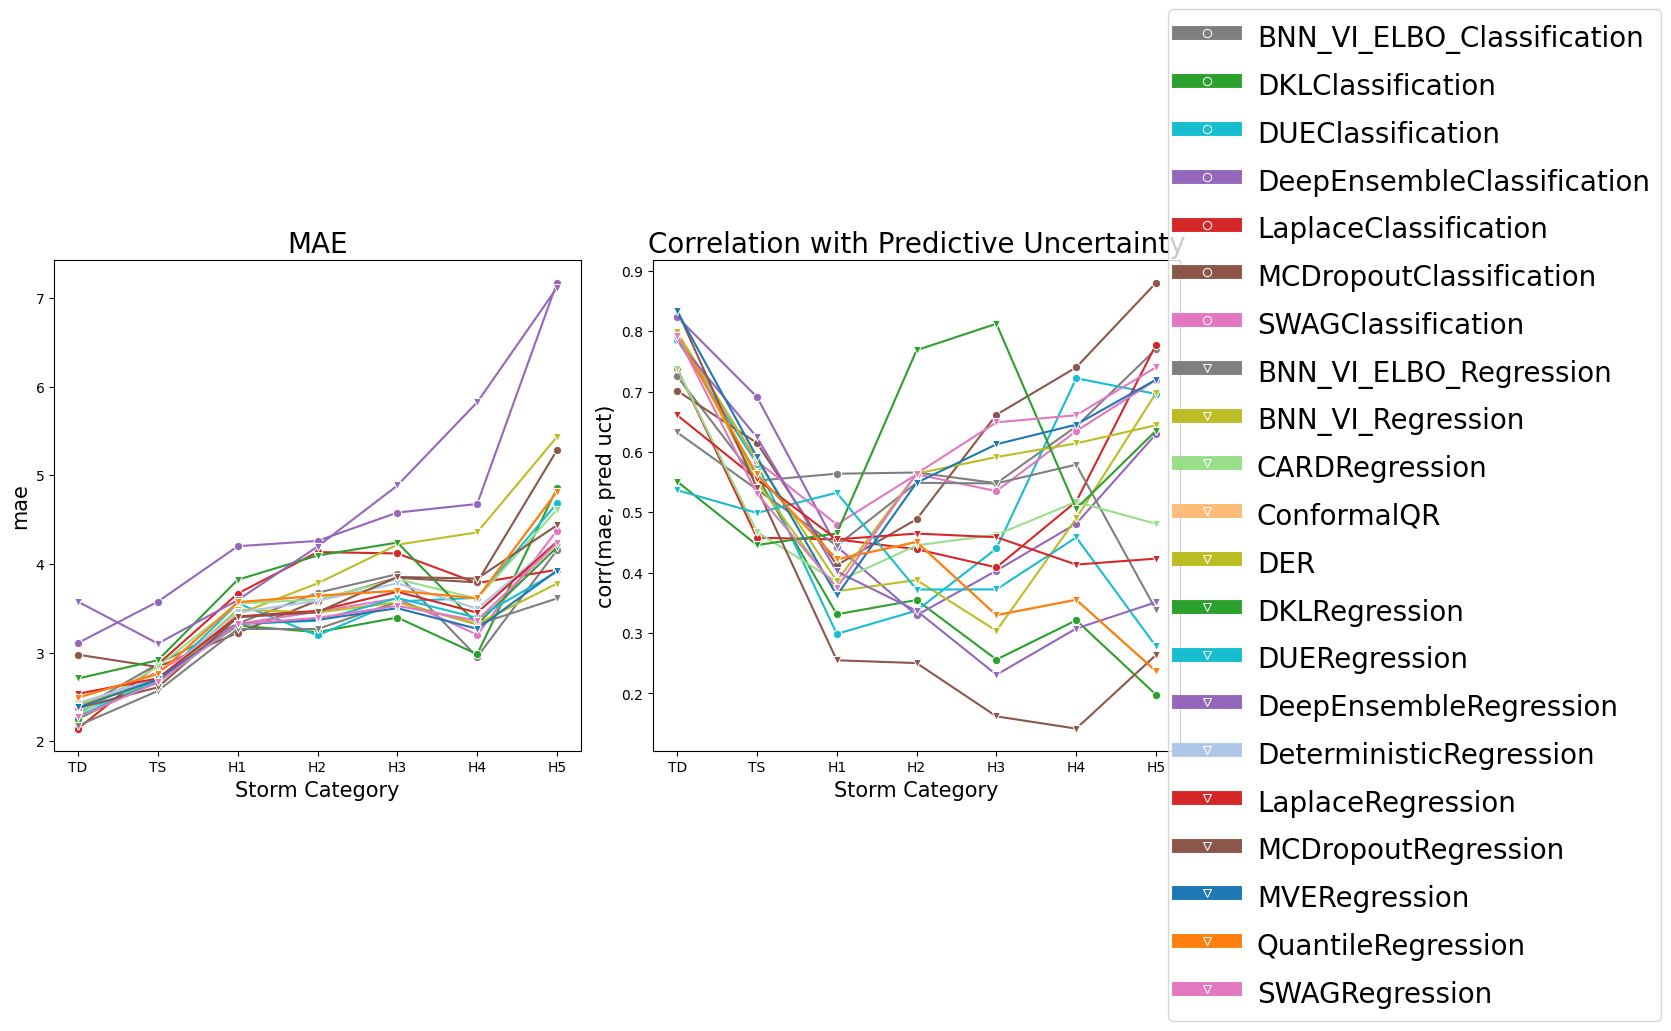

In [47]:
import math

def plot_metrics_by_category(category_df, split_type, method_type):
    plot_cat_df = category_df[(category_df["split"] == f"preds_{split_type}") & (category_df["method_type"].isin(method_type))]

    metrics = [
        "mae",
        # "proportion_in_0.9_interval",
        # "nll",
        # "sharpness",
        # "pred_uct",
        # "rmse",
        # "mace",
        "correlation",
    ]

    # Calculate the number of rows and columns for the subplots
    num_metrics = len(metrics)
    num_cols = len(metrics)
    num_rows = math.ceil(num_metrics / num_cols)

    # Create the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to easily iterate over it

    plot_cat_df.loc[:, "storm_category"] = pd.Categorical(
        plot_cat_df["storm_category"].astype(str), categories=STORM_DISPLAY_ORDER, ordered=True
    )

    plot_cat_df = plot_cat_df[plot_cat_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_cat_df["storm_category"] = plot_cat_df[
        "storm_category"
    ].cat.remove_unused_categories()



    # Loop through the metrics
    for i, metric in enumerate(metrics):
        # Create the sns plot
        sns.lineplot(
            x="storm_category",
            y=metric,
            hue="uqmethod",
            data=plot_cat_df[plot_cat_df["method_type"]=="Classification"],
            ax=axes[i],
            marker="o",
            palette=color_palette,
        )
        sns.lineplot(
            x="storm_category",
            y=metric,
            hue="uqmethod",
            data=plot_cat_df[plot_cat_df["method_type"]=="Regression"],
            ax=axes[i],
            marker="v",
            palette=color_palette,
        )

        # Add title and increase the size
        axes[i].set_title(f"{VAR_TO_PLOT_LABEL[metric]}", fontsize=20)

        # Increase the size of the x and y labels
        axes[i].set_xlabel("Storm Category", fontsize=15)
        if "proportion" in metric:
            axes[i].set_ylabel("prop. interval", fontsize=15)
        elif metric == "correlation":
            axes[i].set_ylabel("corr(mae, pred uct)", fontsize=15)
            axes[i].set_title("Correlation with Predictive Uncertainty", fontsize=20)
        else:
            axes[i].set_ylabel(metric, fontsize=15)

        # Increase the size of the x and y ticks
        axes[i].tick_params(axis="both", which="major", labelsize=10)

    # Hide the remaining unused subplots
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axes[j])

    # set the linewidths to the copies
    handles, labels = axes[0].get_legend_handles_labels()
    [ha.set_linewidth(10) for ha in handles]

    # Replace the labels using the VAR_TO_PLOT_LABEL dictionary
    # labels = [
    #     VAR_TO_PLOT_LABEL[label] if label in VAR_TO_PLOT_LABEL else label
    #     for label in labels
    # ]

    # Increase the size of the legend labels
    fig.legend(
        handles,
        labels,
        loc="center right",
        bbox_to_anchor=(1.4, 0.5),
        fontsize=20,
        handleheight=1.5,
    )

    # Remove individual legends
    for ax in axes.flat:
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


# Call the function with 'train' or 'val' as the argument
plot_metrics_by_category(category_df, DS_SPLIT, ["Regression", "Classification"])

5 5.025021354893159


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


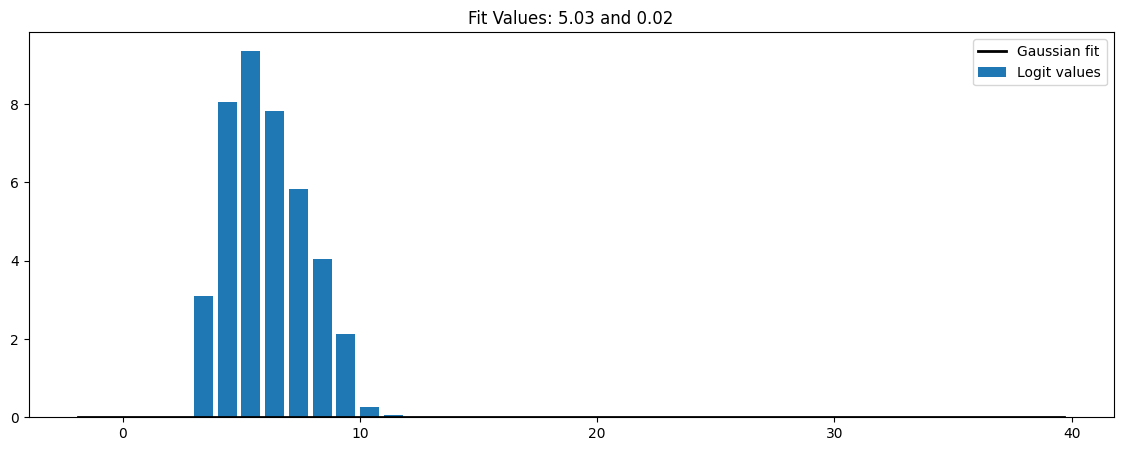

In [ ]:
logit_cols = [col for col in all_test_pred_df.columns if col.startswith("logit_")]

# Compute softmax values for each logit
# exp_logits = np.exp(all_test_pred_df[logit_cols].values)
# softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
logits = all_test_pred_df[logit_cols].values

logits_softplus = np.log1p(np.exp(logits))

bin_intervals = np.diff(WIND_SPEED_BINS) / 2
bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

# Select the first row of softmax values
softplus_row = logits_softplus[20, :]

from scipy.optimize import curve_fit


# Define a Gaussian function
def gaussian(x, mu, std):
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std) ** 2)


# Fit a Gaussian to the softmax values
popt, pcov = curve_fit(gaussian, np.arange(len(softplus_row)), softplus_row, p0=[0, 1])

# Extract the fitted parameters
mu, std = popt

# Plot the softmax values as a bar plot
plt.bar(np.arange(len(softplus_row)), softplus_row, align="edge", label="Logit values")

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gaussian(x, mu, std)
plt.plot(x, p, "k", linewidth=2, label="Gaussian fit")

# Add a title and legend
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.legend()

print(np.argmax(softplus_row), mu)
# Display the plot
plt.show()

,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,date,argmax_reg,softmax_weighted_reg,method_type,TARGET_MEAN,TARGET_STD,point_pred,mse,mae,storm_category
561925,5.0,1.309181,6.0,acd,0.0,33.0,0.000016,0.000016,0.000016,0.005847,...,NaT,27.5,30.152882,Classification,NaN,NaN,27.5,30.25,5.5,TS
561926,5.0,1.312035,6.0,acd,1.0,33.0,0.000016,0.000016,0.000016,0.005768,...,NaT,27.5,30.192694,Classification,NaN,NaN,27.5,30.25,5.5,TS
561927,5.0,1.221888,6.0,acd,2.0,32.0,0.000029,0.000029,0.000029,0.013380,...,NaT,27.5,28.378984,Classification,NaN,NaN,27.5,20.25,4.5,TD
561928,5.0,1.197257,6.0,acd,3.0,32.0,0.000083,0.000083,0.000083,0.031726,...,NaT,27.5,26.785273,Classification,NaN,NaN,27.5,20.25,4.5,TD
561929,5.0,1.234924,6.0,acd,4.0,31.0,0.000032,0.000032,0.000033,0.013476,...,NaT,27.5,28.466921,Classification,NaN,NaN,27.5,12.25,3.5,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605555,4.0,1.236866,4.0,zza,43630.0,20.0,0.001335,0.001286,0.001306,0.133363,...,NaT,22.5,25.270188,Classification,NaN,NaN,22.5,6.25,2.5,TD
605556,4.0,1.309053,4.0,zza,43631.0,20.0,0.002320,0.002230,0.002263,0.156707,...,NaT,22.5,26.259762,Classification,NaN,NaN,22.5,6.25,2.5,TD
605557,4.0,1.263098,4.0,zza,43632.0,20.0,0.001645,0.001577,0.001605,0.140719,...,NaT,22.5,25.569041,Classification,NaN,NaN,22.5,6.25,2.5,TD
605558,4.0,1.298882,4.0,zza,43633.0,20.0,0.002120,0.002034,0.002064,0.151415,...,NaT,22.5,26.057234,Classification,NaN,NaN,22.5,6.25,2.5,TD


count    43635.000000
mean         1.826970
std          0.416352
min          1.178031
25%          1.451511
50%          1.860127
75%          2.159141
max          3.286030
Name: pred_uct, dtype: float64


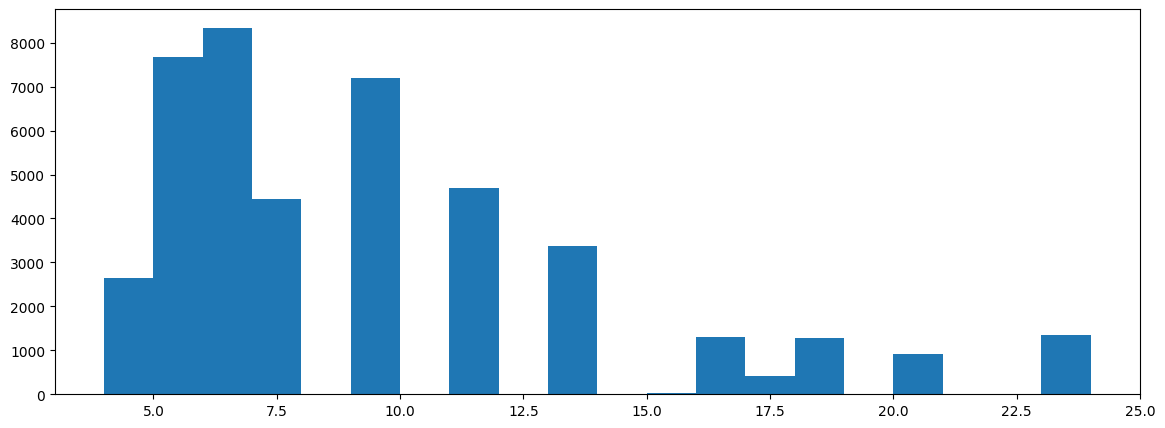

In [ ]:
with pd.option_context("display.max_colwidth", None):
    df = all_test_pred_df[
        (all_test_pred_df["uqmethod"] == "DKLClassification")
        & (all_test_pred_df["split"] == "preds_test")
    ]
    display(df)
    fig, ax = plt.subplots(1)
    ax.hist(df["pred"], bins=20, label="target")
    print(df["pred_uct"].describe())
    plt.show()

In [ ]:
def compute_metrics(df, pred_col: str):
    df["mse"] = (df[pred_col] - df["wind_speed"]) ** 2
    df["mae"] = np.abs(df[pred_col] - df["wind_speed"])
    metric_df = (
        df.groupby(["uqmethod", "split", "pred_path"])
        .agg({"mse": "mean", "mae": "mean"})
        .reset_index()
    )
    metric_df["rmse"] = metric_df["mse"].apply(np.sqrt)
    return metric_df


# choose over which pred type column to compute the metrics
with pd.option_context("display.max_colwidth", None):
    display(compute_metrics(all_test_pred_df, "argmax_reg"))

,uqmethod,split,pred_path,mse,mae,rmse
0,BNN_VI_ELBO_Classification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_test.csv,116.802905,7.994443,10.807539
1,BNN_VI_ELBO_Classification,preds_train,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_train.csv,89.653315,6.947984,9.468543
2,BNN_VI_ELBO_Classification,preds_val,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_val.csv,122.058805,8.150314,11.048023
3,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445/preds_test.csv,NaN,NaN,NaN
4,BNN_VI_ELBO_Regression,preds_train,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445/preds_train.csv,NaN,NaN,NaN
...,...,...,...,...,...,...
58,SWAGClassification,preds_train,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_train.csv,90.804376,7.045751,9.529133
59,SWAGClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,123.803362,8.246105,11.126696
60,SWAGRegression,preds_test,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_SWAGRegression_02-01-2024_16-18-46-884277/preds_test.csv,NaN,NaN,NaN
61,SWAGRegression,preds_train,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_SWAGRegression_02-01-2024_16-18-46-884277/preds_train.csv,NaN,NaN,NaN


        pred  pred_uct  target storm_id    index  wind_speed       logit_0  \
274213   7.0  1.725556     8.0      zsh  43242.0        40.0  4.485997e-07   

             logit_1       logit_2   logit_3  ...  date  argmax_reg  \
274213  4.310134e-07  4.208395e-07  0.000002  ...   NaT        37.5   

        softmax_weighted_reg     method_type  TARGET_MEAN  TARGET_STD  \
274213             42.826098  Classification          NaN         NaN   

        point_pred   mse  mae  storm_category  
274213        37.5  6.25  2.5              TS  

[1 rows x 63 columns]
43242.0


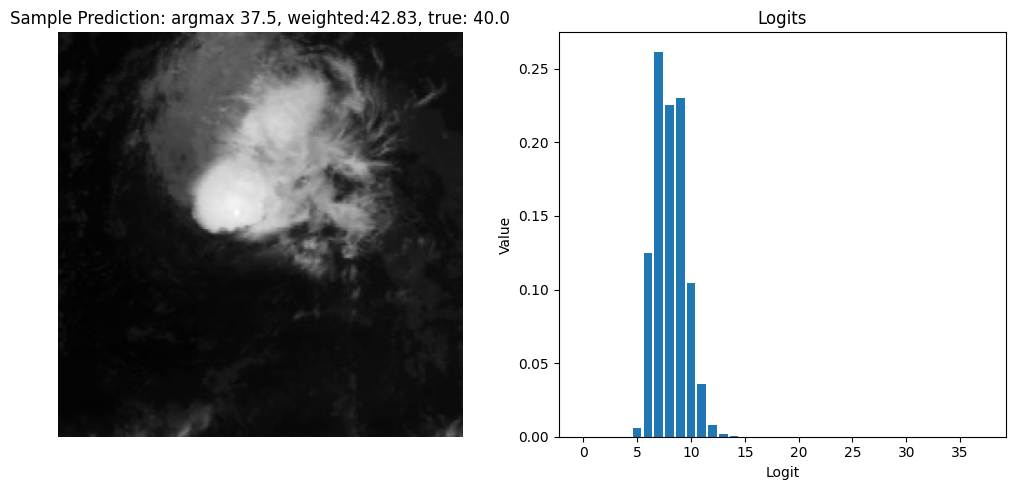

In [ ]:
import matplotlib.pyplot as plt


def plot_method(all_test_pred_df, method: str, data_split: str):
    # Select rows for the given method
    df_method = all_test_pred_df[all_test_pred_df["uqmethod"] == method]
    df_method = df_method[df_method["split"] == f"preds_{data_split}"]

    # If there's no data for the given method, return
    if df_method.empty:
        print(f"No data for method: {method}")
        return

    # Select a random row (sample) from the dataframe
    sample = df_method.sample(1)

    # Extract logit columns (columns that start with 'logt_')
    logit_cols = [col for col in df_method.columns if col.startswith("logit_")]
    logits = sample[logit_cols].values[0]

    # Create a figure with two subplots: one for the prediction, one for the logits
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    print(sample)
    print(sample["index"].iloc[0])
    img = DS_DICT[data_split][int(sample["index"].iloc[0])]["input"]
    # Plot prediction
    axs[0].imshow(img[0, ...], cmap="gray")
    axs[0].set_title(
        f'Sample Prediction: argmax {sample["argmax_reg"].iloc[0]}, weighted:{sample["softmax_weighted_reg"].iloc[0]:.2f}, true: {sample["wind_speed"].iloc[0]}'
    )
    axs[0].set_xlabel("Index")
    axs[0].axis("off")
    axs[0].set_ylabel("Prediction")

    # Plot logits
    axs[1].bar(range(len(logit_cols)), logits)
    axs[1].set_title("Logits")
    axs[1].set_xlabel("Logit")
    axs[1].set_ylabel("Value")

    # Display the plot
    plt.tight_layout()
    plt.show()


plot_method(all_test_pred_df, "DUEClassification", DS_SPLIT)